
# 🔤 Artificial Neural Network (ANN) — Alphabets Dataset (One-Hot Target)
**Objective:** Classify letters using a feed-forward ANN with **one-hot encoded** targets and manual hyperparameter tuning.


## 1) Setup & Imports

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore", message=r"Protobuf gencode version .* is exactly one major version older")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

pd.set_option('display.max_columns', None)


## 2) Load & Inspect Data

In [4]:
import pandas as pd

df = pd.read_csv(r"D:\DATA-SCIENCE\ASSIGNMENTS\18 neural networks\Alphabets_data.csv")
print("Shape:", df.shape)
df.head()


Shape: (20000, 17)


,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


## 3) Basic EDA

          count     mean       std  min  25%  50%  75%   max
xbox    20000.0  4.02355  1.913212  0.0  3.0  4.0  5.0  15.0
ybox    20000.0  7.03550  3.304555  0.0  5.0  7.0  9.0  15.0
width   20000.0  5.12185  2.014573  0.0  4.0  5.0  6.0  15.0
height  20000.0  5.37245  2.261390  0.0  4.0  6.0  7.0  15.0
onpix   20000.0  3.50585  2.190458  0.0  2.0  3.0  5.0  15.0

Nulls per column:
 letter    0
xbox      0
ybox      0
width     0
height    0
onpix     0
xbar      0
ybar      0
x2bar     0
y2bar     0
xybar     0
x2ybar    0
xy2bar    0
xedge     0
xedgey    0
yedge     0
yedgex    0
dtype: int64

Class distribution:
 letter
A    789
B    766
C    736
D    805
E    768
F    775
G    773
H    734
I    755
J    747
K    739
L    761
M    792
N    783
O    753
P    803
Q    783
R    758
S    748
T    796
U    813
V    764
W    752
X    787
Y    786
Z    734
Name: count, dtype: int64


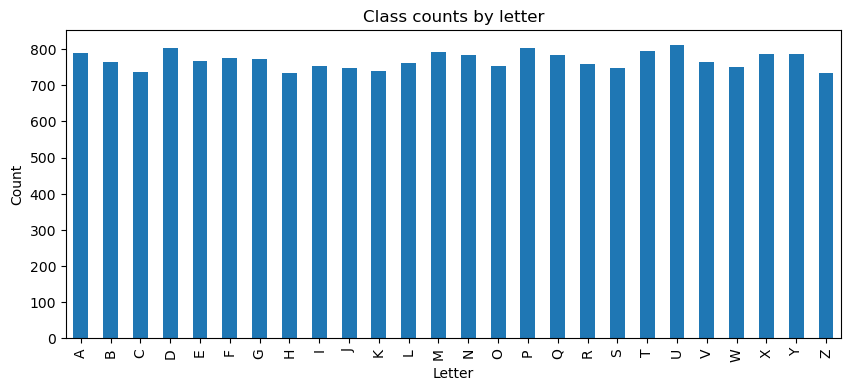

In [5]:
import matplotlib.pyplot as plt

print(df.describe().T.head())
print("\nNulls per column:\n", df.isnull().sum())
print("\nClass distribution:\n", df['letter'].value_counts().sort_index())
plt.figure(figsize=(10,4))
df['letter'].value_counts().sort_index().plot(kind='bar')
plt.title("Class counts by letter")
plt.xlabel("Letter")
plt.ylabel("Count")
plt.show()


## 4) Preprocessing — One-Hot Target + Feature Scaling

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

RANDOM_STATE = 42

# Split features/target
y_raw = df['letter'].astype(str)
X = df.drop(columns=['letter']).astype(float)

# Train/Test split (stratified by letter)
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y_raw, test_size=0.2, random_state=RANDOM_STATE, stratify=y_raw
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# One-Hot encode the target
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_train = ohe.fit_transform(y_train_raw.to_numpy().reshape(-1,1))
y_test  = ohe.transform(y_test_raw.to_numpy().reshape(-1,1))

num_classes = y_train.shape[1]
input_dim = X_train_scaled.shape[1]
classes = ohe.categories_[0].tolist()

print("Input dim:", input_dim, " Num classes:", num_classes)
print("Classes (A-Z):", classes[:10], "... total:", len(classes))


Input dim: 16  Num classes: 26
Classes (A-Z): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'] ... total: 26


## 5) Model Builder — Keras Sequential

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

RANDOM_STATE = 42


def build_ann(input_dim, num_classes, hidden_layers=[128, 64], activation='relu', lr=1e-3, dropout=0.0):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for units in hidden_layers:
        model.add(layers.Dense(units, activation=activation))
        if dropout and dropout > 0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
print("Ready. build_ann + EarlyStopping defined ✅")
# If you already ran your preprocessing:
# input_dim = X_train_scaled.shape[1]
# num_classes = y_train.shape[1]

# If not, set some placeholders just to test the function:
# input_dim, num_classes = 16, 26

test_model = build_ann(input_dim, num_classes)
test_model.summary()  # <- this will print a table




Ready. build_ann + EarlyStopping defined ✅


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,122 (47.35 KB)

 Trainable params: 12,122 (47.35 KB)

 Non-trainable params: 0 (0.00 B)

## 6) Baseline Model — Train & Evaluate

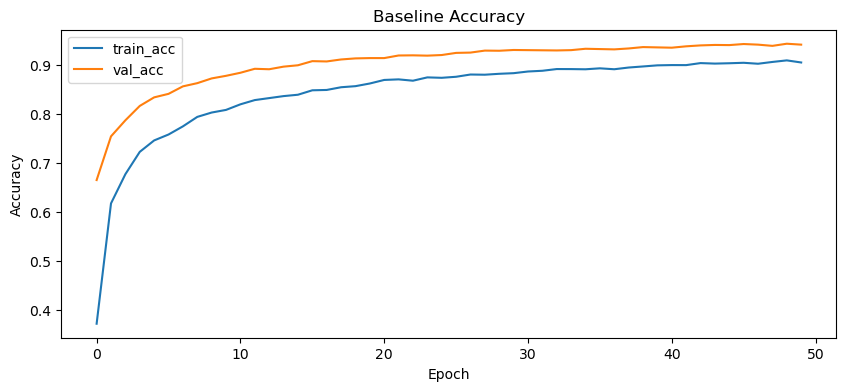

Baseline Test Accuracy: 0.944

Classification Report (Baseline):
               precision    recall  f1-score   support

           A       0.98      0.96      0.97       158
           B       0.86      0.91      0.88       153
           C       0.92      0.98      0.95       147
           D       0.93      0.96      0.94       161
           E       0.92      0.95      0.94       154
           F       0.94      0.93      0.93       155
           G       0.96      0.92      0.94       155
           H       0.95      0.85      0.90       147
           I       0.99      0.90      0.94       151
           J       0.95      0.97      0.96       149
           K       0.93      0.94      0.93       148
           L       0.94      0.95      0.94       152
           M       0.99      0.95      0.97       158
           N       0.96      0.92      0.94       157
           O       0.89      0.95      0.92       150
           P       0.97      0.93      0.95       161
           Q   

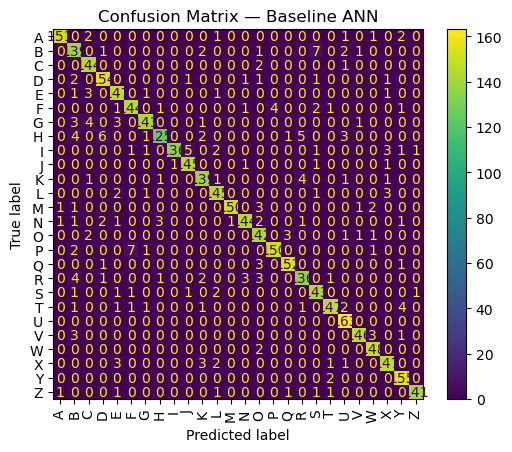

In [8]:

baseline_params = {
    'hidden_layers': [128, 64],
    'activation': 'relu',
    'lr': 1e-3,
    'dropout': 0.2,
    'batch_size': 64,
    'epochs': 50
}

model = build_ann(input_dim, num_classes,
                  hidden_layers=baseline_params['hidden_layers'],
                  activation=baseline_params['activation'],
                  lr=baseline_params['lr'],
                  dropout=baseline_params['dropout'])

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    batch_size=baseline_params['batch_size'],
    epochs=baseline_params['epochs'],
    callbacks=[es],
    verbose=0
)

# Plot training curves
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Baseline Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test
y_prob = model.predict(X_test_scaled, verbose=0)
y_pred_idx = y_prob.argmax(axis=1)
y_true_idx = y_test.argmax(axis=1)

test_acc = accuracy_score(y_true_idx, y_pred_idx)
print("Baseline Test Accuracy:", test_acc)

# Per-class metrics using string labels
y_pred_labels = [classes[i] for i in y_pred_idx]
y_true_labels = [classes[i] for i in y_true_idx]

print("\nClassification Report (Baseline):\n",
      classification_report(y_true_labels, y_pred_labels, zero_division=0))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=classes)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix — Baseline ANN")
plt.show()


## 7) Hyperparameter Tuning — Manual Grid Search

In [14]:

param_grid = {
    'hidden_layers': [
        [128, 64],
        [256, 128],
        [256, 128, 64]
    ],
    'activation': ['relu', 'tanh'],
    'lr': [1e-3, 5e-4],
    'dropout': [0.0, 0.2, 0.4],
    'batch_size': [64, 128],
    'epochs': [40]  # keep moderate for demonstration
}

best_score = -np.inf
best_cfg = None
results = []

for hidden_layers in param_grid['hidden_layers']:
    for activation in param_grid['activation']:
        for lr in param_grid['lr']:
            for dropout in param_grid['dropout']:
                for batch_size in param_grid['batch_size']:
                    # Build & train
                    m = build_ann(input_dim, num_classes, hidden_layers, activation, lr, dropout)
                    hist = m.fit(
                        X_train_scaled, y_train,
                        validation_split=0.2,
                        batch_size=batch_size,
                        epochs=param_grid['epochs'][0],
                        callbacks=[es],
                        verbose=0
                    )
                    val_acc = max(hist.history['val_accuracy'])
                    results.append({
                        'hidden_layers': hidden_layers,
                        'activation': activation,
                        'lr': lr,
                        'dropout': dropout,
                        'batch_size': batch_size,
                        'val_acc': val_acc
                    })
                    if val_acc > best_score:
                        best_score = val_acc
                        best_cfg = (hidden_layers, activation, lr, dropout, batch_size)

print("Best VAL accuracy:", best_score)
print("Best config:", best_cfg)

tune_df = pd.DataFrame(results).sort_values(by='val_acc', ascending=False)
tune_df.head(10)


Best VAL accuracy: 0.9353125095367432
Best config: ([256, 128], 'relu', 0.001, 0.0, 64)


,hidden_layers,activation,lr,dropout,batch_size,val_acc
24,"[256, 128]",relu,0.0010,0.0,64,0.935313
48,"[256, 128, 64]",relu,0.0010,0.0,64,0.932813
60,"[256, 128, 64]",tanh,0.0010,0.0,64,0.930625
26,"[256, 128]",relu,0.0010,0.2,64,0.924375
25,"[256, 128]",relu,0.0010,0.0,128,0.923125
49,"[256, 128, 64]",relu,0.0010,0.0,128,0.922500
61,"[256, 128, 64]",tanh,0.0010,0.0,128,0.919375
36,"[256, 128]",tanh,0.0010,0.0,64,0.918125
54,"[256, 128, 64]",relu,0.0005,0.0,64,0.917500
50,"[256, 128, 64]",relu,0.0010,0.2,64,0.916875


## 8) Best Model — Retrain & Evaluate on Test

In [10]:
# 1) Minimal dims — set these if your preprocessing cell isn't in memory yet
input_dim  = globals().get('input_dim', 16)   # features = 16 for Alphabets_data
num_classes = globals().get('num_classes', 26)

# 2) Build the model
test_model = build_ann(input_dim, num_classes, hidden_layers=[128, 64], activation='relu', lr=1e-3, dropout=0.2)

# 3) Ensure it's built (sometimes summary is blank if graph isn't concretized)
#    With an Input layer this shouldn't be needed, but we’ll force it anyway:
try:
    test_model.build((None, input_dim))
except Exception as e:
    print("build() warning (safe to ignore):", e)

# 4) Force-print the summary even in environments that swallow stdout
from io import StringIO
buf = StringIO()
test_model.summary(print_fn=lambda x: buf.write(x + "\n"))
print(buf.getvalue() or "⚠️ summary() returned nothing")

# 5) Final check: if you STILL see nothing, confirm stdout works at all:
print("If you can read this, stdout is working ✅")


Model: "sequential_74"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_246 (Dense)                    │ (None, 128)                 │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_114 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_247 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_115 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────

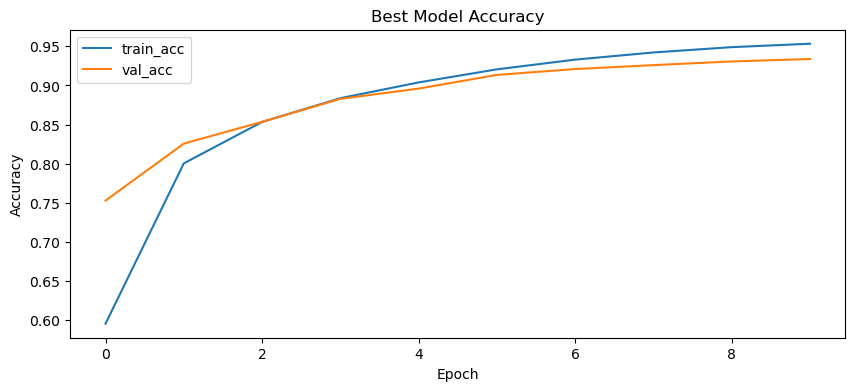

Best Model — Test Accuracy: 0.7495

Classification Report (Best):
               precision    recall  f1-score   support

           A       0.83      0.89      0.86       158
           B       0.66      0.80      0.73       153
           C       0.80      0.83      0.81       147
           D       0.57      0.86      0.69       161
           E       0.66      0.87      0.75       154
           F       0.73      0.71      0.72       155
           G       0.76      0.43      0.55       155
           H       0.85      0.31      0.45       147
           I       0.91      0.73      0.81       151
           J       0.79      0.82      0.81       149
           K       0.63      0.82      0.72       148
           L       0.97      0.78      0.87       152
           M       0.72      0.94      0.81       158
           N       0.78      0.81      0.80       157
           O       0.85      0.73      0.79       150
           P       0.73      0.87      0.79       161
           Q  

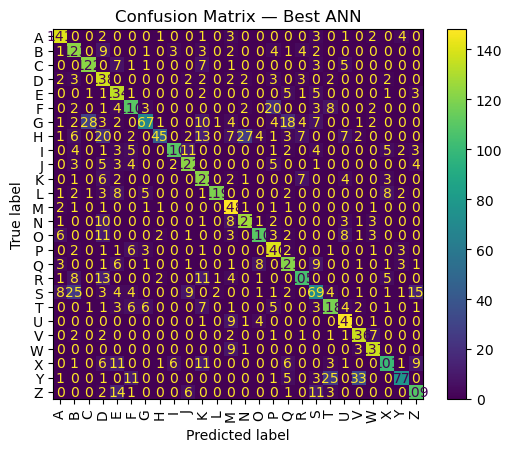

In [11]:

hidden_layers, activation, lr, dropout, batch_size = best_cfg

best_model = build_ann(input_dim, num_classes, hidden_layers, activation, lr, dropout)
hist_best = best_model.fit(
    X_train_scaled, y_train, validation_split=0.2,
    batch_size=batch_size, epochs=60, callbacks=[es], verbose=0
)

# Plot training curves for best model
plt.figure(figsize=(10,4))
plt.plot(hist_best.history['accuracy'], label='train_acc')
plt.plot(hist_best.history['val_accuracy'], label='val_acc')
plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_prob_best = best_model.predict(X_test_scaled, verbose=0)
y_pred_idx_best = y_prob_best.argmax(axis=1)
y_true_idx = y_test.argmax(axis=1)

print("Best Model — Test Accuracy:", accuracy_score(y_true_idx, y_pred_idx_best))

y_pred_labels_best = [classes[i] for i in y_pred_idx_best]
y_true_labels = [classes[i] for i in y_true_idx]

print("\nClassification Report (Best):\n",
      classification_report(y_true_labels, y_pred_labels_best, zero_division=0))

cm_best = confusion_matrix(y_true_labels, y_pred_labels_best, labels=classes)
disp = ConfusionMatrixDisplay(cm_best, display_labels=classes)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix — Best ANN")
plt.show()


## 9) Baseline vs Best — Summary

In [12]:

# Gather baseline & best metrics quickly
baseline_acc = test_acc
best_acc = accuracy_score(y_true_idx, y_pred_idx_best)

summary = pd.DataFrame([
    {'model': 'baseline', 'acc': baseline_acc},
    {'model': 'best', 'acc': best_acc}
])

summary


,model,acc
0,baseline,0.9440
1,best,0.7495



## 10) Notes & Interview Q&A

**Why one-hot for targets?**  
Softmax output + categorical cross-entropy expects a probability distribution per class; one-hot encoding enables that cleanly.

**Key ANN hyperparameters to tune:**  
- Hidden layers & units (capacity)  
- Activation functions (`relu`, `tanh`)  
- Learning rate (optimizer step)  
- Dropout (regularization)  
- Batch size & epochs (optimization dynamics)  

**When to stop training?**  
Use EarlyStopping on `val_loss` to avoid overfitting and reduce compute.

**Why scale features?**  
Helps optimization converge faster and more stably for dense layers.
